General info:                 
Size of the subset:           3519
Mean of the flux:             

2.125678e6
Variance of the flux:         209420.36
Variance of the errors:       0.002832904
Mean of the time differences: 0.026614859881868173
Lomb–Scargle periodogram:
The peak is at 0.2222989453247285.
The relevant estimate of the period is 4.498446893390457.
At least 216 points are required to infer this period.


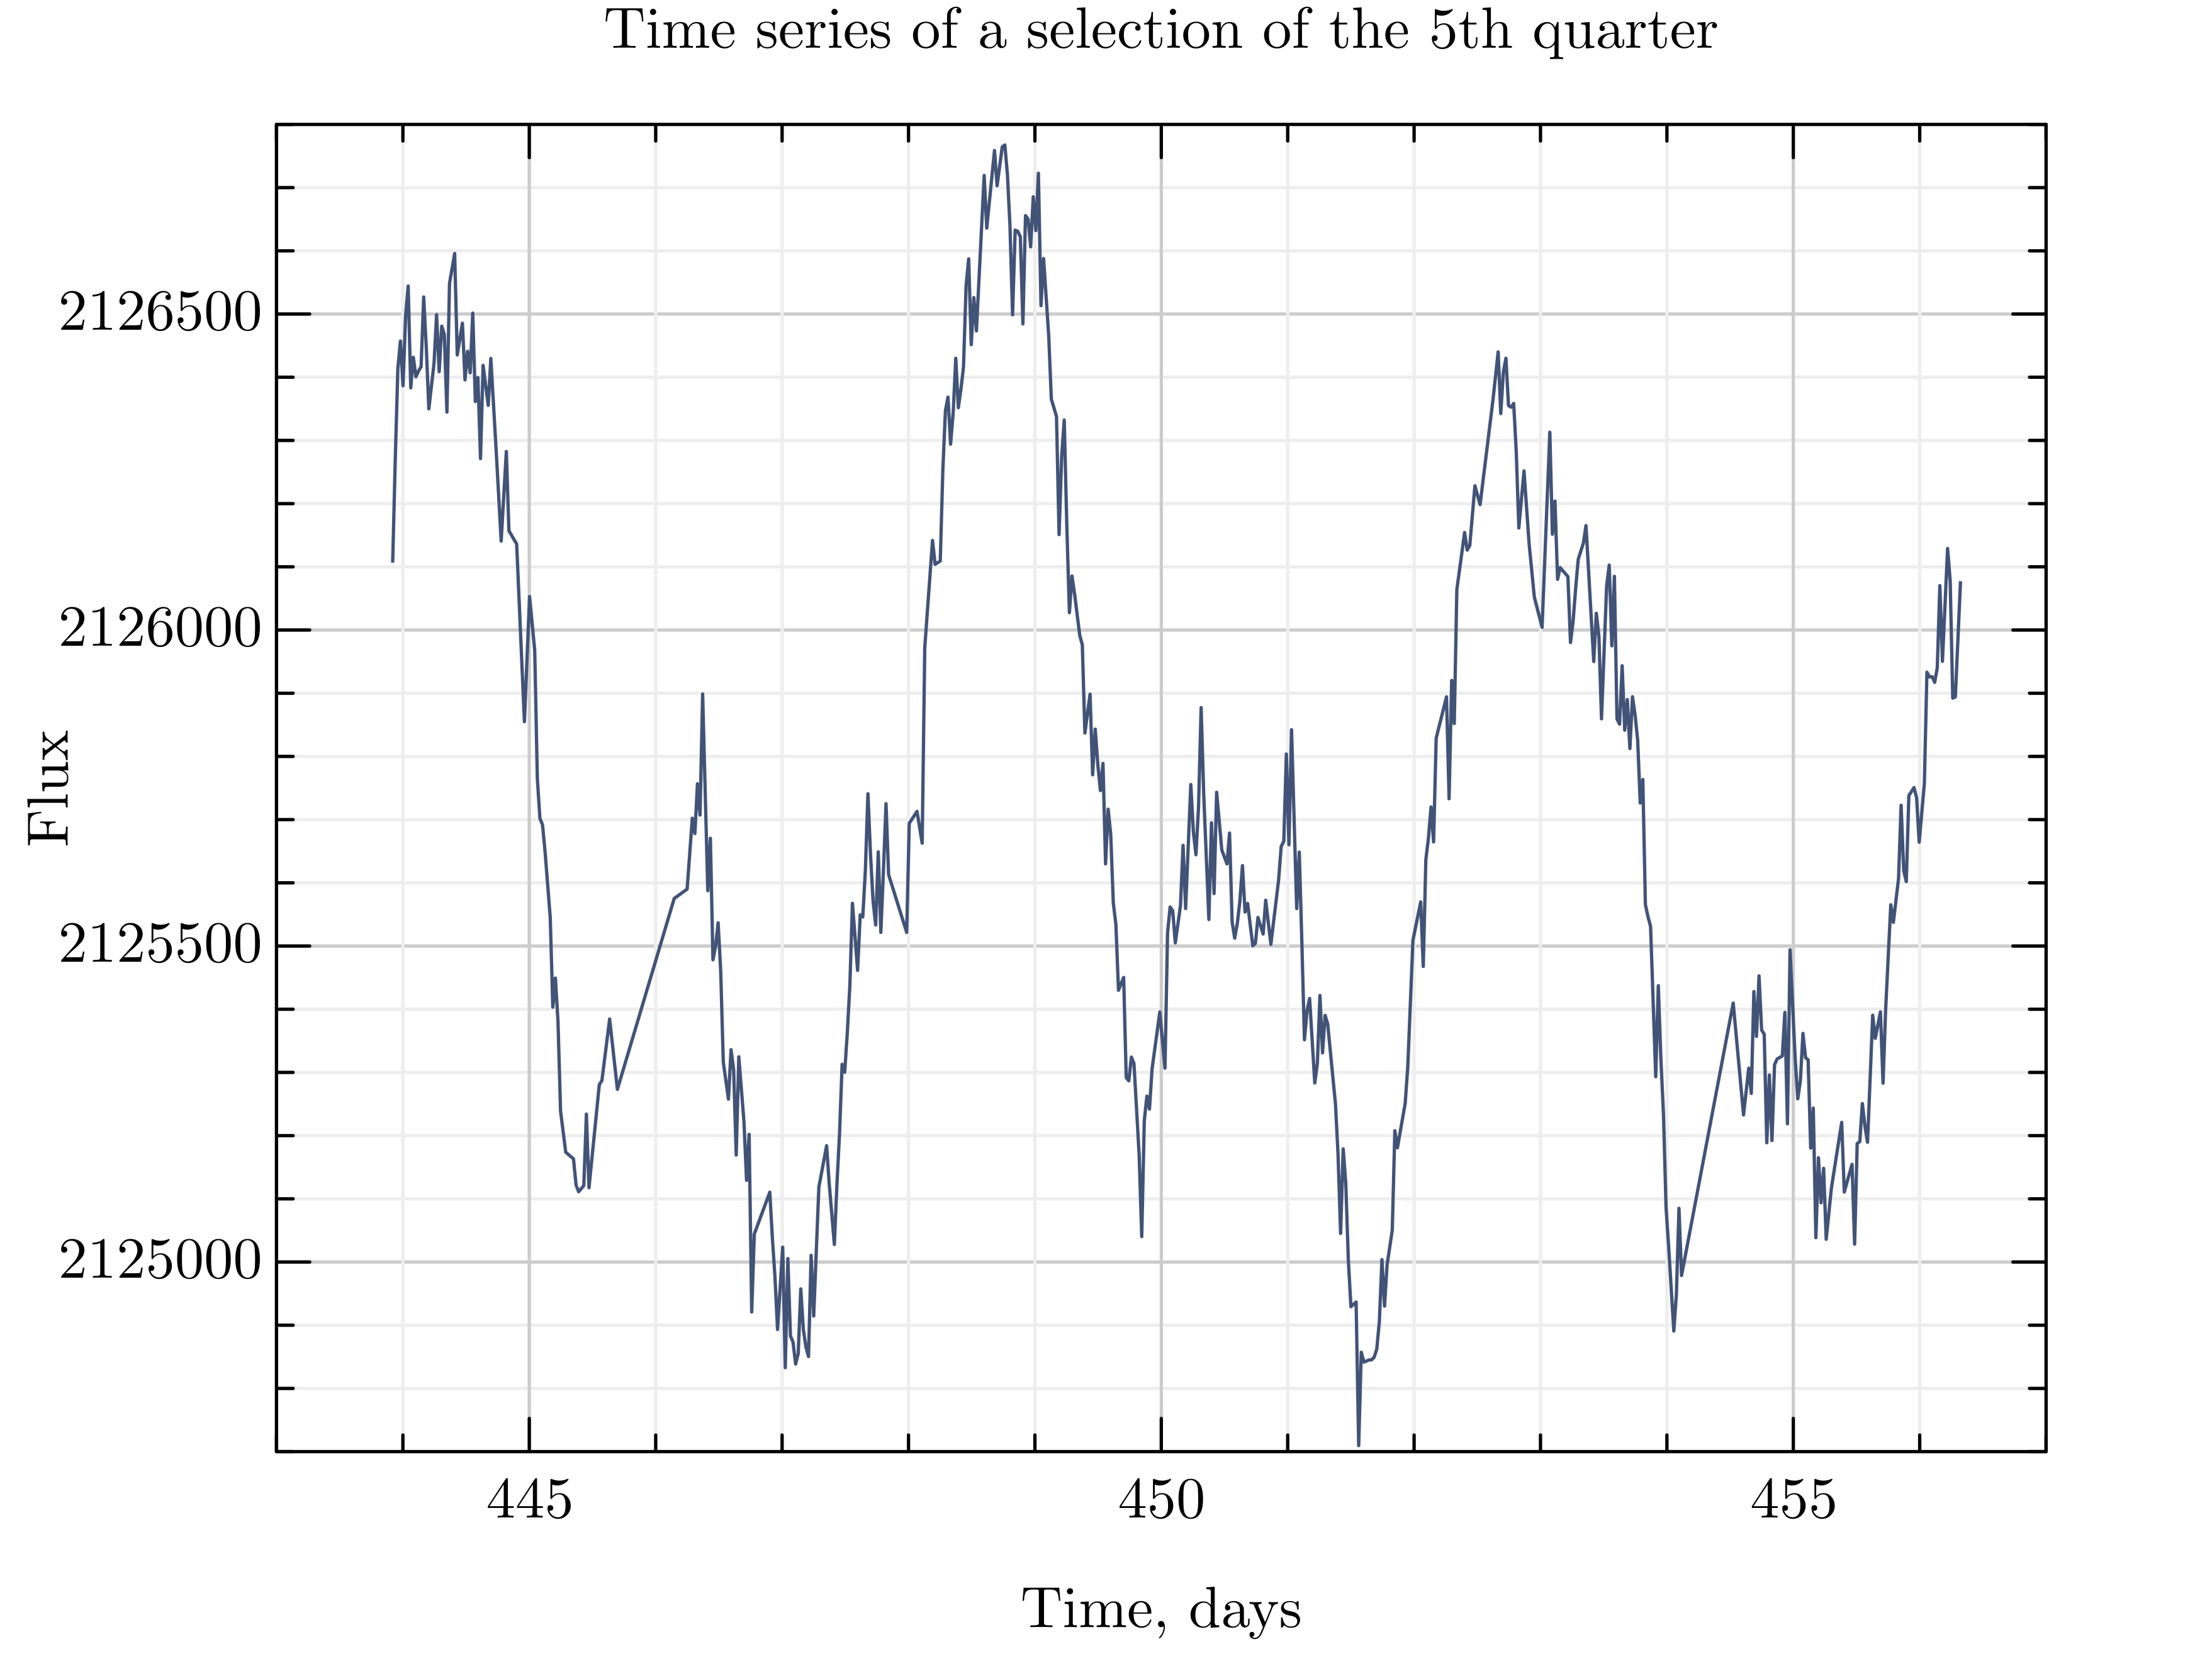

In [1]:
using NBInclude
@nbinclude("../KIC1430163.ipynb")

In [2]:
struct EQPKernel <: KernelFunctions.SimpleKernel
    A::Real
    l::Real
    P::Real
end

KernelFunctions.kappa(k::EQPKernel, τ::Real) = k.A * exp(-0.5 * τ^2 / k.l^2) * cos(2 * π * τ / k.P)
KernelFunctions.metric(k::EQPKernel) = KernelFunctions.Euclidean()

In [3]:
# Unpack a tuple of parameters
function unpack(θ)
    A = θ[1]
    l = θ[2]
    P = θ[3]
    μ = θ[4]
    σ²ₙ = θ[5]
    return A, l, P, μ, σ²ₙ
end

# Calculate the negative log marginal likelihood
function nlml(θ)
    A, l, P, μ, σ²ₙ = unpack(θ)
    k = EQPKernel(A, l, P)
    g = GP(μ, k, GPC())
    return -logpdf(g(tₛ, σ²ₙ), fₛ)
end
;

Negative log marginal likelihood: 2844.4323116686264


GKS: invalid workstation type (Base.RefValue{String}("Base.RefValue{String}(\"svg\")"))


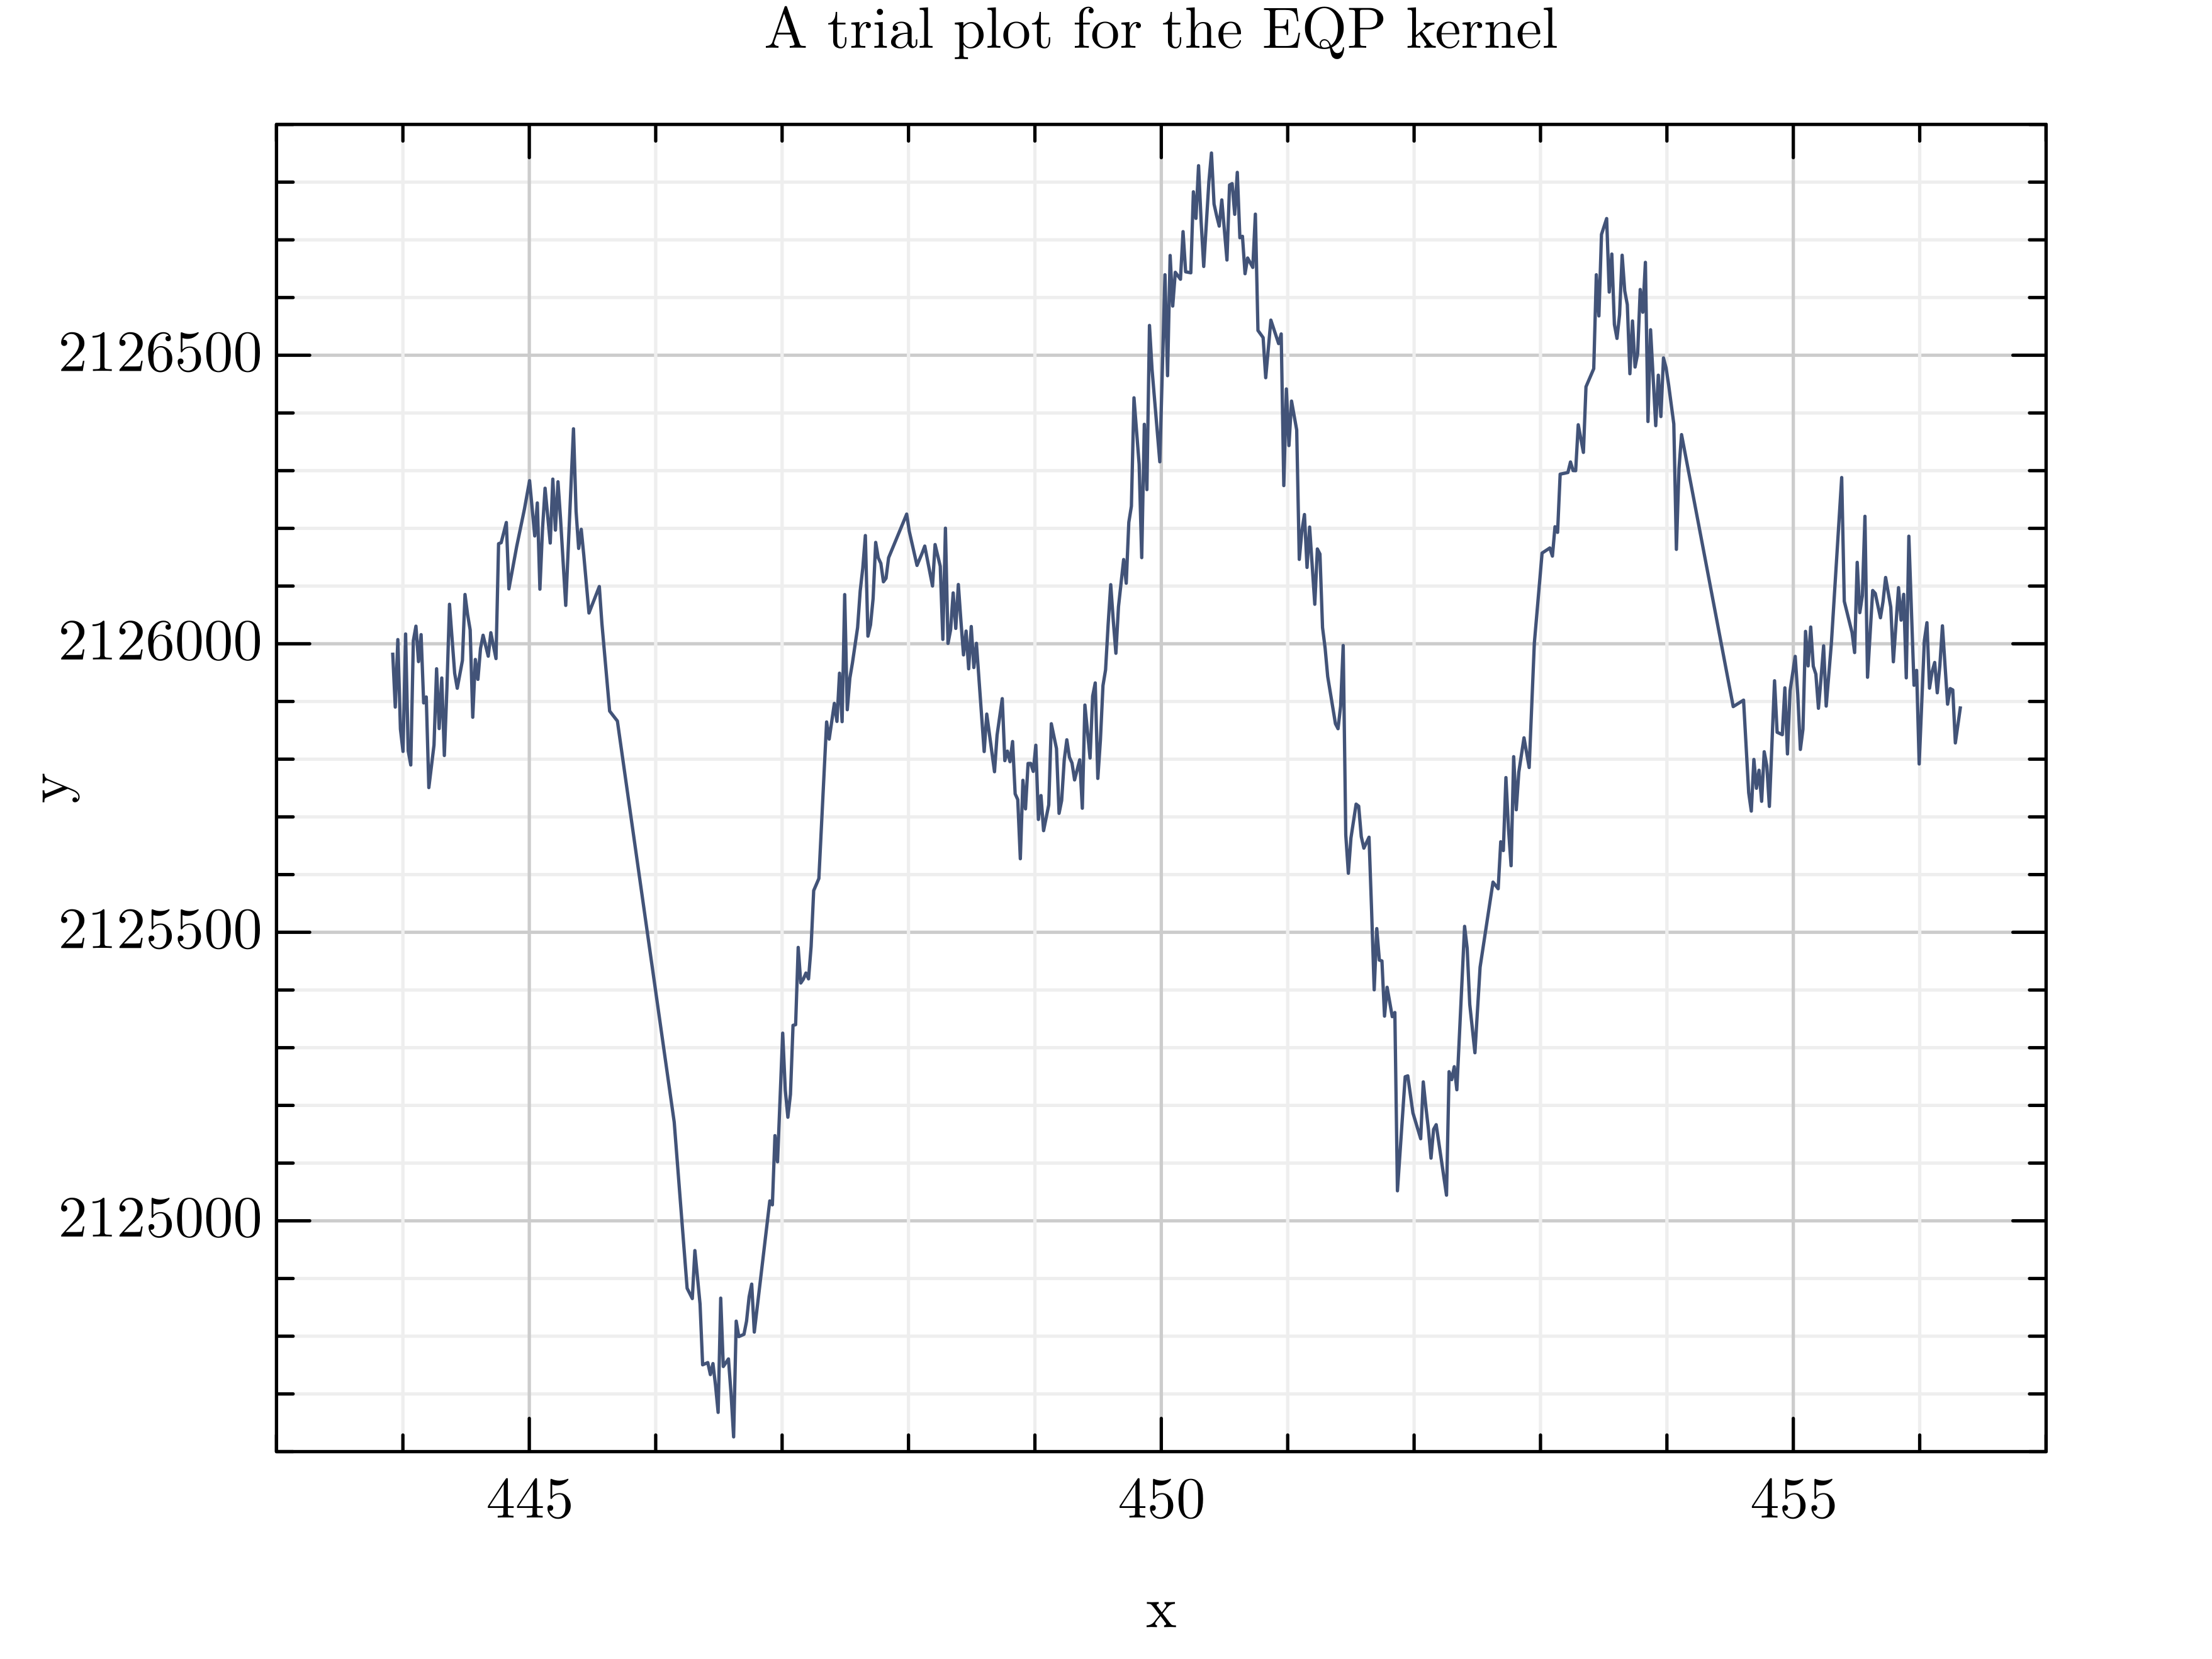

In [4]:
# Select the trial parameters
Aₜ = Aₛ
lₜ = 1.0
Pₜ = P₀
μₜ = μₛ
σ²ₙₜ = 5500

# Initialize the test kernel
k = EQPKernel(Aₜ, lₜ, Pₜ)

# Create a Gaussian process
g = GP(μₜ, k, GPC())

# Take the values of one of the Gaussian process realizations
# on the time values of the original time series
x = tₛ
y = rand(g(x, σ²ₙₜ))

plot(x, y; linecolor)

title("A trial plot for the EQP kernel")
xlabel("x")
ylabel("y")

θₜ = [Aₜ, lₜ, Pₜ, μₜ, σ²ₙₜ]
println("Negative log marginal likelihood: ", nlml(θₜ))

gcf()

In [5]:
# Collect a parameters vector
θ₀ = [Aₜ, lₜ, Pₜ, μₜ, σ²ₙₜ]

# Define the lower and upper boundaries, respectively
θₗ = [Aₜ - 2000, lₜ - 0.25, 1.0, μₜ - 2000, σ²ₙₜ - 2000]
θᵤ = [Aₜ + 2000, lₜ + 1.0, 6.0, μₜ + 2000, σ²ₙₜ + 2000]

# Print the boundaries
println("Lower boundaries:", '\n', θₗ, '\n')
println("Upper boundaries:", '\n', θᵤ, '\n')

# Optimize the negative log marginal likelihood function
results = Optim.optimize(
    nlml,
    θ->Zygote.gradient(nlml, θ)[1],
    θₗ,
    θᵤ,
    θ₀,
    Fminbox(LBFGS()),
    Optim.Options(
        show_trace = true,
        extended_trace = true,
        store_trace = false,
    );
    inplace = false,
)

Lower boundaries:
[252975.625, 0.75, 1.0, 2.12370275e6, 3500.0]

Upper boundaries:
[256975.625, 2.0, 6.0, 2.12770275e6, 7500.0]

Fminbox
-------
Initial mu = 0.135303

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.135303

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     2.838225e+03     7.301518e+02
 * Current step size: 1.0
 * time: 0.045202016830444336
 * g(x): [-6.2076806879431246, 730.1517842598614, 63.093794694718206, -6.205937121058599, -6.252142028218192]
 * x: [254975.625, 1.0, 4.498446893390457, 2.12570275e6, 5500.0]
     1     2.722027e+03     1.463988e+02
 * Current step size: 0.0011269954862857226
 * time: 21.152201890945435
 * g(x): [-8.097005655047436e-5, 146.3988279401298, 18.87563842250489, 0.0007064840397747694, -0.02903403427566875]
 * x: [254975.63199602763, 0.7506549707514992, 4.4320584011142365, 2.1257027569940626e6, 5500.007046135369]
     2     2.662056e+03     1.912059e+02
 * Current s

LoadError: InterruptException:

In [6]:
# Take the last set of parameters
θᵣ = results.minimizer

# Create a kernel
k = EQPKernel(θᵣ[1], θᵣ[2], θᵣ[3])

# Create a Gaussian process
g = GP(θᵣ[4], k, GPC())

# Take the values of one of the Gaussian process realizations
# on the time values of the original time series
x = tₛ
y = rand(g(x, θᵣ[5]))

plot(x, y; linecolor)

title("Using the last set of parameters")
xlabel("x")
ylabel("y")

println("Negative log marginal likelihood: ", nlml(θᵣ))

gcf()

LoadError: UndefVarError: results not defined

GKS: invalid workstation type (Base.RefValue{String}("Base.RefValue{String}(\"Base.RefValue{String}(\\\"Base.RefValue{String}(\\\\\\\"svg\\\\\\\")\\\")\")"))


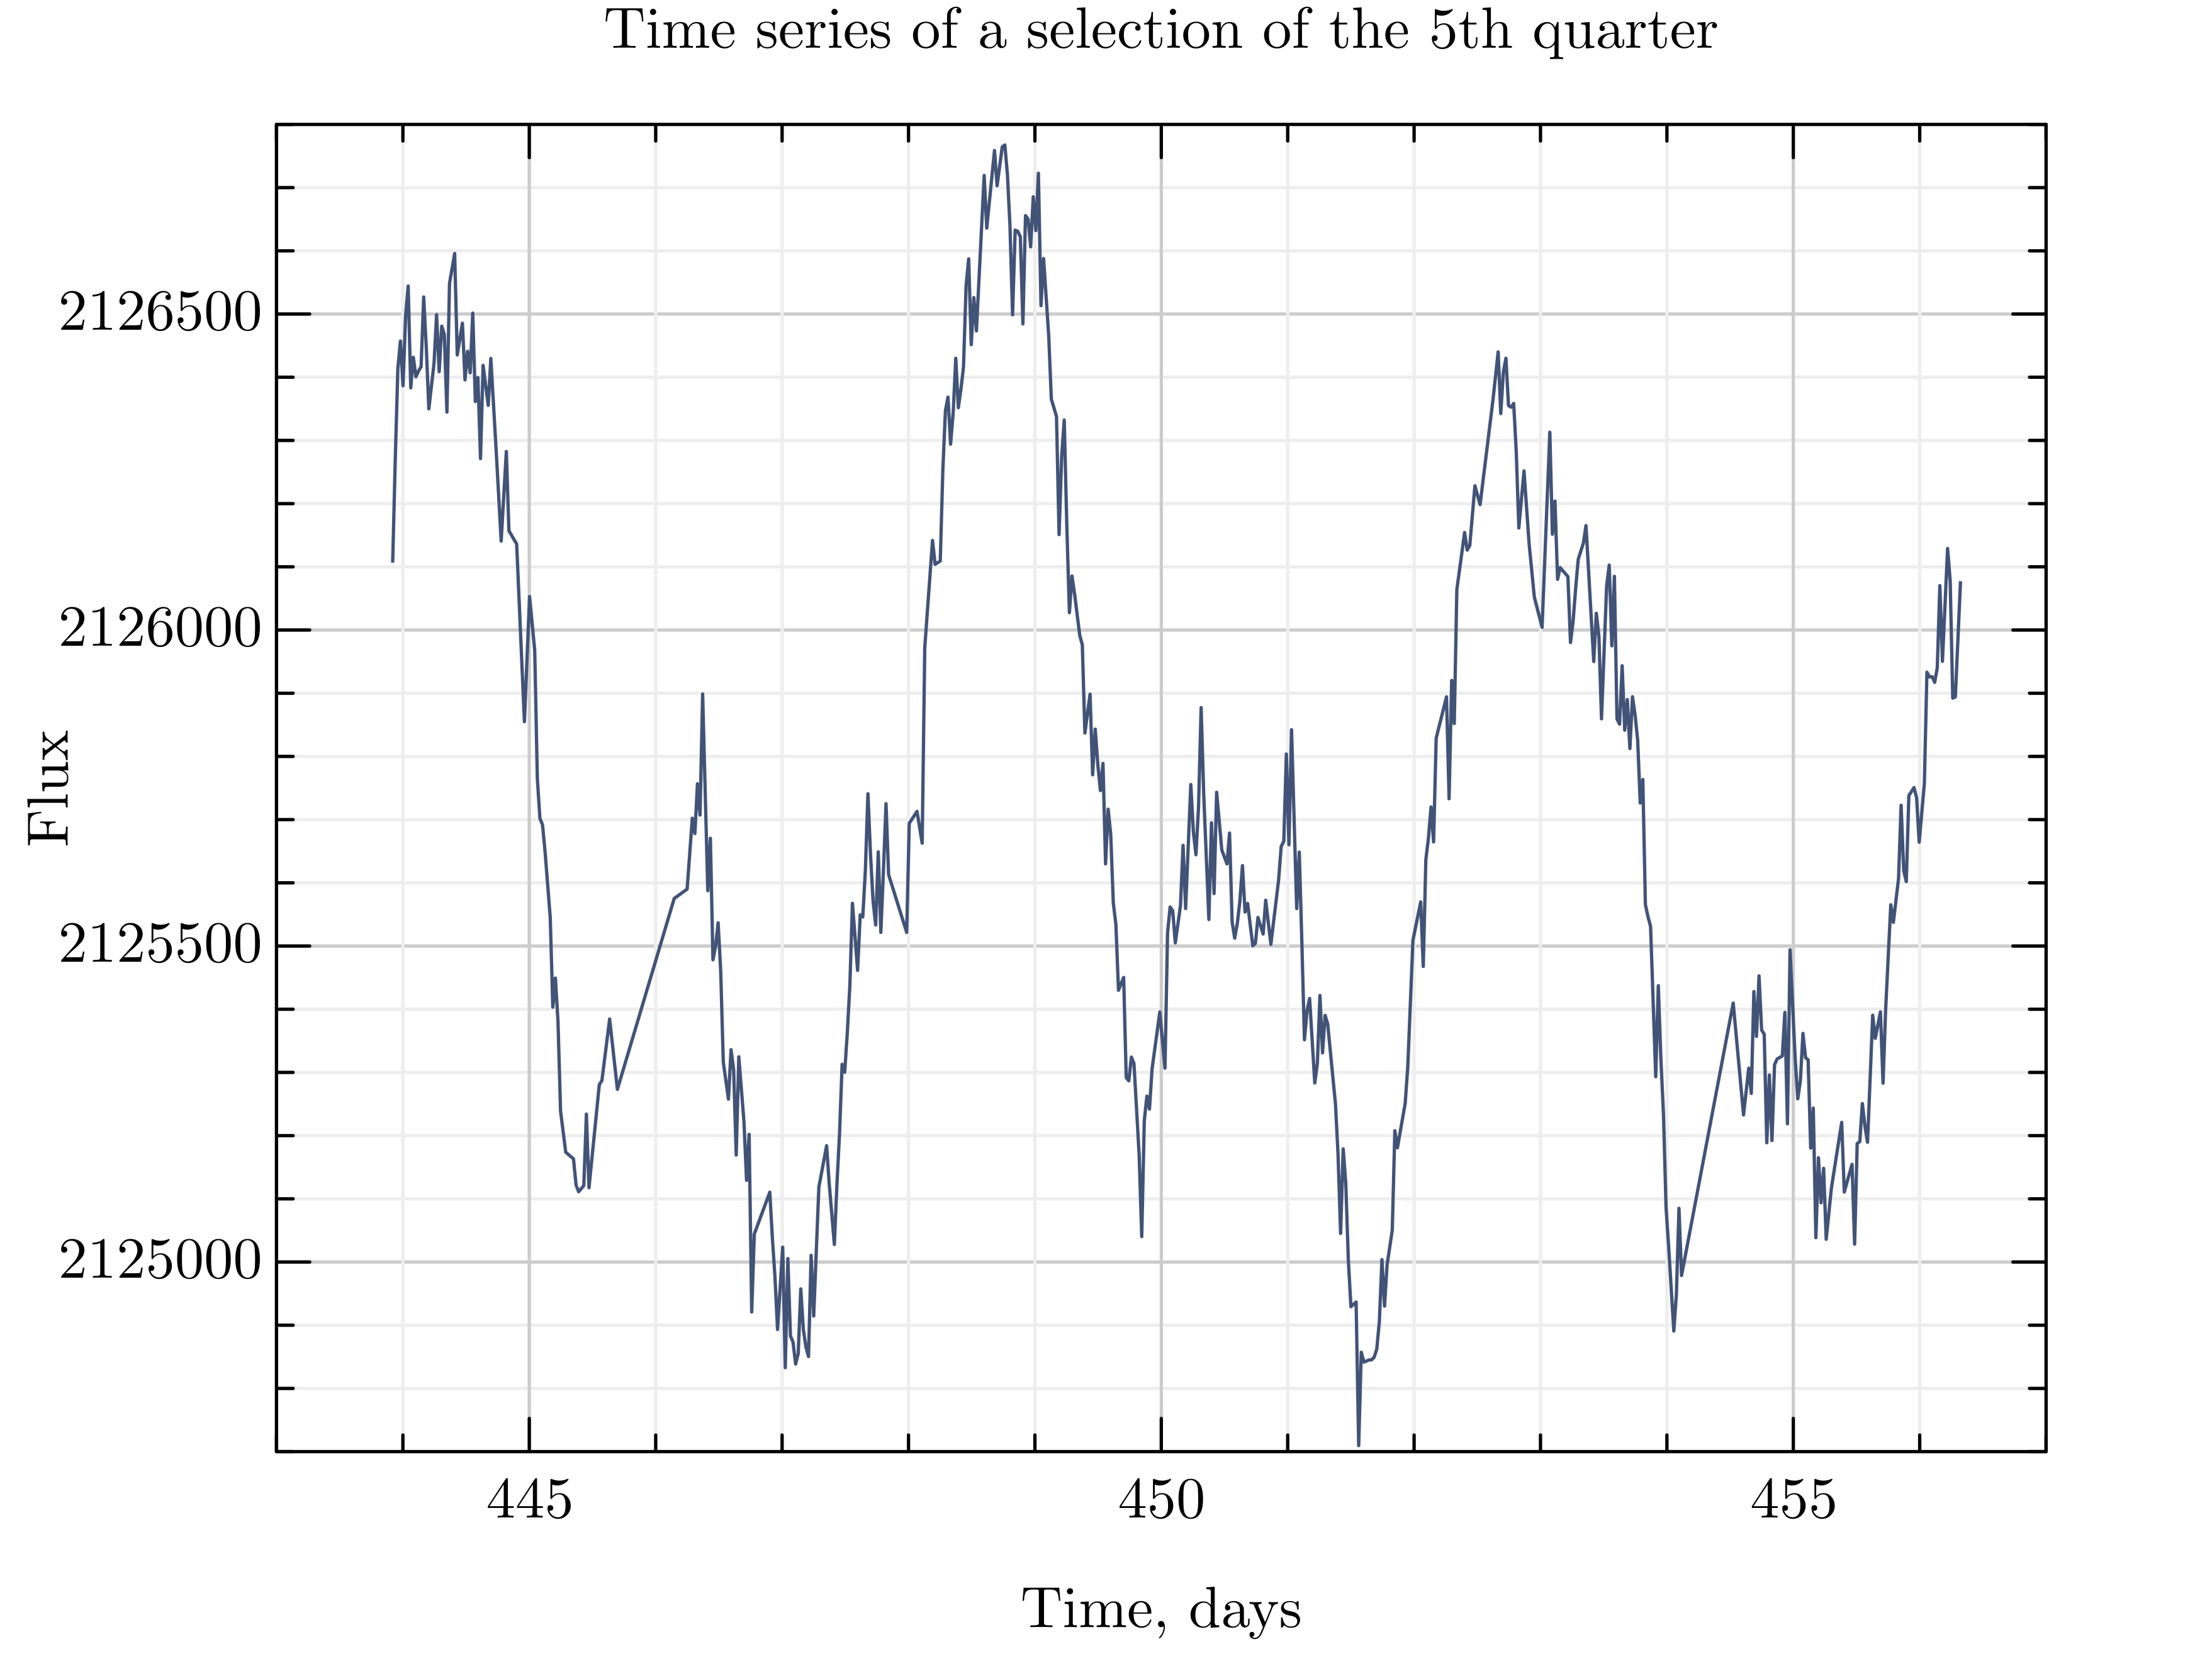

In [7]:
plot(tₛ, fₛ; linecolor)

xlabel("Time, days")
ylabel("Flux")
title("Time series of a selection of the 5th quarter")